Importing required libraries to predict acceleration using random forest, calculate RMSE (RootMeanSquaredError), and create plots to compare predicted and actual acceleration

In [37]:
import pandas as pd
import numpy as np

#import src
import FileProcessing
import ModelClass
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Bidirectional, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

import tensorflow
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import FileProcessing
import RFmodel

from sklearn.neighbors import KNeighborsRegressor


In [2]:
fileProcessing=FileProcessing.FileProcessing()

In [3]:
model_obj=ModelClass.ModelClass()
file=FileProcessing.FileProcessing()

In [4]:
file_name='Cleaned_NGSIM_Data'
ngsim=fileProcessing.read_input(file_name)

original File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


In [5]:
def fit_and_run_KNN(df, time_frame):
    shift_instance = time_frame*10
    df, train_df, val_df, test_df, X_train, y_train, X_val, y_val, X_test, y_test = model_obj.preprocessing(df, shift_instance)
    return df, train_df, val_df, test_df, X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
def define_KNN( input_df):
    model = KNeighborsRegressor(n_neighbors=5)
    #model = SVR(kernel='linear')

    return model

In [7]:
delta_time=0.1
ngsim_1, train_df_1, val_df_1, test_df_1, X_train_1, y_train_1, X_val_1, y_val_1, X_test_1, y_test_1= fit_and_run_KNN(ngsim, delta_time)

In [8]:
model=define_KNN(train_df_1)

In [9]:
ngsim=ngsim_1
train_df= train_df_1
val_df=val_df_1,
test_df= test_df_1
X_train= X_train_1
y_train=y_train_1
X_val=X_val_1
y_val=y_val_1
X_test=X_test_1
y_test=y_test_1
time_frame=delta_time
reaction_time=delta_time

In [10]:

def fit_KNN(model, X_train, y_train, reaction_time):
    modelName = "SVM_model" + str(reaction_time) + ".keras"
    save_callback = keras.callbacks.ModelCheckpoint(
        modelName, save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', verbose=1, patience=7)
        
    model.fit(X_train, y_train)
    return model


In [11]:
model=fit_KNN( model,X_train, y_train, reaction_time)

In [12]:
import pickle 
pickle.dump(model, open('svm_0.1.pkg', 'wb'))

In [30]:

predict_on_pair = model_obj.prediction_test_pairs(test_df, 10, 12)
#predict_on_pair[0]
print(f"Prediction being done on :{predict_on_pair[0]}")
target_variable = 'nextframeAcc'
predict_on_pair = model_obj.prediction_test_pairs(test_df_1, 10, 12)
#current_pair=predict_on_pair[0]
#predict_on_pair=current_pair
target_variable = 'nextframeAcc'
#current_pair='422-427'


Prediction being done on :477-484


In [41]:
predict_on_pair

['477-484', '496-503']

In [68]:
def prediction(test,unique_pairs_df,target_variable,abc,delta_time):
    predicted_df = []
    input_df = pd.DataFrame()
    # unique_pairs_df is the test range
    for i in unique_pairs_df:
        # Q this is the input data frame
        input_df = test[test['L-F_Pair']== i]
        spacing = np.zeros(input_df.shape[0])
        local_y_subject = np.zeros(input_df.shape[0])
        local_y_preceding = np.zeros(input_df.shape[0])
        dv = np.zeros(input_df.shape[0])
        vel = np.zeros(input_df.shape[0])
        pred_acc = np.zeros(input_df.shape[0])

        vel[0] = input_df.iloc[0]['v_Vel']
        spacing[0] = input_df.iloc[0]['Rear_to_Front_Space_Headway']
        dv[0] = input_df.iloc[0]['Velocity Difference_Following-Preceding']

        local_y_subject[0] = input_df.iloc[0]['Local_Y']
        local_y_preceding[0] = input_df.iloc[0]['preceding_Local_Y']
        preceding_vehicle_class = input_df.iloc[0]['preceding_v_Class']
        vehicle_class = input_df.iloc[0]['v_Class']
        length_preceding_vehicle = input_df.iloc[0]['preceding_vehicle_length']

        predict_for_input = np.array(
            [spacing[0], preceding_vehicle_class, vehicle_class, dv[0], vel[0]]).reshape(1, -1)
        pred_acc[0] = abc.predict(predict_for_input)
        print(
            f"j: {0} input:{predict_for_input},subject localy:{local_y_subject[0]},preceding_local_y:{local_y_preceding[0]},spacing:{spacing[0]} pred_acc: {pred_acc[0]}")
        vel[1] = vel[0]+(pred_acc[0]*delta_time)


        dv[1] = vel[1] - input_df.iloc[1]['preceding_Vehicle_Velocity']

        s_subject = ((vel[0]*delta_time ) +
                        (0.5*pred_acc[0]*pow(delta_time, 2)))
                        #should be 1  second here

        local_y_subject[1] = local_y_subject[0] + s_subject
        local_y_preceding[1] = input_df.iloc[1]['preceding_Local_Y'] 

        spacing[1] = local_y_preceding[1] - \
            local_y_subject[1] - length_preceding_vehicle

        for j in range(1, len(input_df)):
            predict_for_input = np.array(
                [spacing[j], preceding_vehicle_class, vehicle_class, dv[j], vel[j]]).reshape(1, -1)
            
            pred_acc[j] = abc.predict(predict_for_input)
            if j == len(input_df)-1:
                break
            
            vel[j+1] = vel[j]+(pred_acc[j]*0.1)


            dv[j+1] = vel[j+1] - input_df.iloc[j+1]['preceding_Vehicle_Velocity']


            s_subject = ((vel[j]*0.1) +
                            (0.5*pred_acc[j]*pow(0.1, 2)))
                            

            
            local_y_subject[j+1] = local_y_subject[j] + s_subject
            local_y_preceding[j+1] = input_df.iloc[j+1]['preceding_Local_Y']

            spacing[j+1] = local_y_preceding[j+1] - \
                local_y_subject[j+1] - length_preceding_vehicle

            print(f"j: {j} input:{predict_for_input},subject localy:{local_y_subject[j]},preceding_local_y:{local_y_preceding[j]},spacing:{spacing[j]} pred_acc: {pred_acc[j]}")

        print(f"input_df shape: {input_df.shape}")
        print(f"pred_acc shape: {pred_acc.shape}")
        input_df['predicted_acceleration'] = pred_acc
        input_df['predicted_velocity'] = vel
        input_df['predicted_spacing'] = spacing

        predicted_df.append(input_df)
        result = pd.concat(predicted_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))      
        return result


In [52]:
#predicted_data = model_obj.prediction(test_df, predict_on_pair, target_variable, model, time_frame)
rfobj=RFmodel.ModelClass()
predicted_data = prediction(test_df, predict_on_pair, model, 0.1)
        
        

j: 0 input:[[12.94079208  2.          2.          0.097536    9.62253571]],subject localy:54.35163116455078,preceding_local_y:71.8148422241211,spacing:12.940792083740234 pred_acc: 0.10119360685348511
j: 1 input:[[ 1.29305300e+01  2.00000000e+00  2.00000000e+00 -2.07336545e-03
   9.63265507e+00]],subject localy:55.31439070314169,preceding_local_y:72.76612091064453,spacing:12.93053002744913 pred_acc: -0.10911840200424194
j: 2 input:[[12.96176763  2.          2.         -0.06175325  9.62174323]],subject localy:56.27711061775685,preceding_local_y:73.76007843017578,spacing:12.961767632365223 pred_acc: -0.12313920259475708
j: 3 input:[[12.97648159  2.          2.          0.16977305  9.60942931]],subject localy:57.238669244349005,preceding_local_y:74.7363510131836,spacing:12.976481588780878 pred_acc: -0.356006383895874
j: 4 input:[[12.94055935  2.          2.          0.55174825  9.57382867]],subject localy:58.19783214300871,preceding_local_y:75.65959167480469,spacing:12.940559351742266 pred

In [53]:
test_df

,Local_Y,v_Class,v_Vel,v_Acc,Following,Location,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,...,preceding_Local_Y,preceding_v_Class,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,nextFrameSpacing,precnextframeposition,precnextframesvel
810,70.407578,2,11.750040,-0.938784,44,us-101,12.856464,1.094163,-0.396240,-0.512064,...,88.292938,2.0,0.000000,33.400002,1.002792,11.756136,71.565819,12.908280,89.504211,12.106656
814,71.565819,2,11.756136,1.002792,44,us-101,12.908280,1.098004,-0.350520,1.249680,...,89.504211,2.0,0.100000,33.400002,2.039112,11.884152,72.738388,12.950952,90.717926,12.036552
831,72.738388,2,11.884152,2.039112,44,us-101,12.950952,1.089767,-0.152400,2.965704,...,90.717926,2.0,0.200000,33.400002,1.487424,12.048744,73.939606,12.957048,91.924934,11.878056
838,73.939606,2,12.048744,1.487424,44,us-101,12.957048,1.075386,0.170688,3.709416,...,91.924934,2.0,0.300000,33.400002,0.393192,12.149328,75.159416,12.917424,93.106949,11.634216
853,75.159416,2,12.149328,0.393192,44,us-101,12.917424,1.063221,0.515112,3.316224,...,93.106949,2.0,0.400000,33.400002,-0.024384,12.176760,76.379829,12.844272,94.252693,11.381232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634263,490.396393,2,1.728216,0.000000,2466,i-80,4.178808,2.417989,-0.957072,0.000000,...,498.566833,2.0,83.199997,83.699997,0.000000,1.728216,490.569214,4.273296,498.835388,2.685288
2634265,490.569214,2,1.728216,0.000000,2466,i-80,4.273296,2.472663,-0.957072,0.000000,...,498.835388,2.0,83.300003,83.699997,0.000000,1.728216,490.741730,4.367784,499.103607,2.685288
2634272,490.741730,2,1.728216,0.000000,2466,i-80,4.367784,2.527337,-0.957072,0.000000,...,499.103607,2.0,83.400002,83.699997,0.000000,1.728216,490.914551,4.465320,499.372131,2.685288
2634277,490.914551,2,1.728216,0.000000,2466,i-80,4.465320,2.583774,-0.957072,0.000000,...,499.372131,2.0,83.500000,83.699997,0.000000,1.728216,491.087372,4.559808,499.640961,2.679192


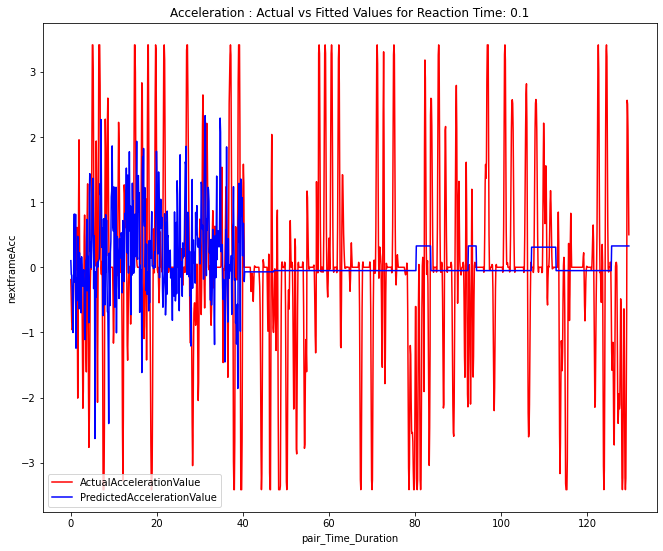

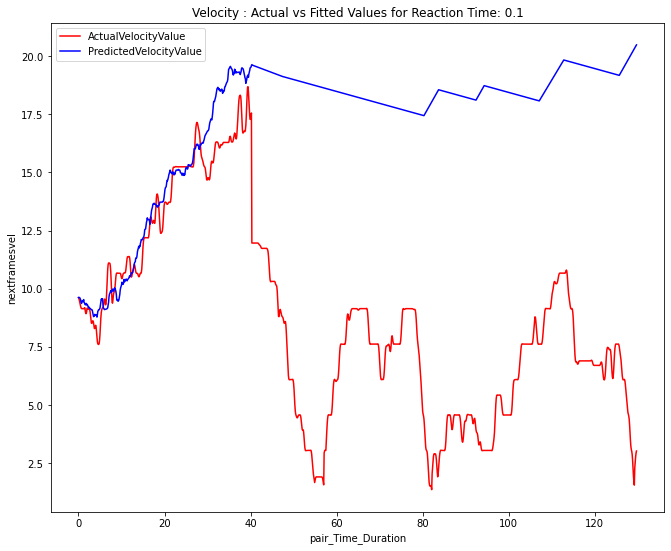

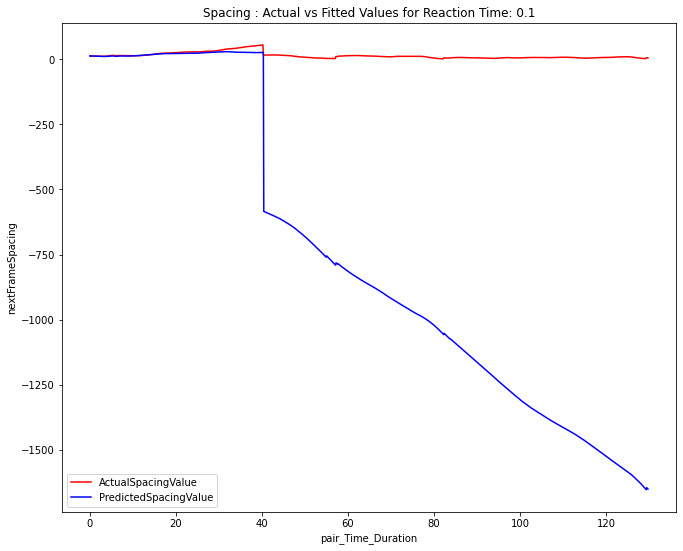

In [55]:
prediction_1 = predicted_data[predicted_data["L-F_Pair"]
                                == predict_on_pair[0]]

model_obj.plot_prediction(prediction_1, 'pair_Time_Duration',
                        'predicted_acceleration', 'nextframeAcc', 'Acceleration', time_frame)
model_obj.plot_prediction(prediction_1, 'pair_Time_Duration',
                        'predicted_velocity', 'nextframesvel', 'Velocity', time_frame)
model_obj.plot_prediction(prediction_1, 'pair_Time_Duration',
                        'predicted_spacing', 'nextFrameSpacing', 'Spacing', time_frame)


In [57]:
#predicted_df.head


predict_on_pair=['477-484']
print(f"Prediction being done on :{predict_on_pair[0]}")
target_variable = 'nextframeAcc'
#predict_on_pair = model_obj.prediction_test_pairs(test_df_1, 10, 12)
#current_pair=predict_on_pair[0]
#predict_on_pair=current_pair
target_variable = 'nextframeAcc'
#current_pair='422-427'

#test_range=predict_on_pair

#predicted_df = []
        # this loop runs for each pair required predictions.

# Assign shape of the predictions
#input_df = []
#input_df = test_df[test_df['L-F_Pair'] == current_pair]
#input_df
predicted_data_model_class=model_obj.prediction(test_df, predict_on_pair, target_variable, model, time_frame)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_acceleration', 'nextframeAcc', 'Acceleration', delta_time)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_velocity', 'nextframesvel', 'Velocity', delta_time)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_spacing', 'nextFrameSpacing', 'Spacing', delta_time)


Prediction being done on :477-484
j: 0 input:[[12.94079208  2.          2.          0.097536    9.62253571]],subject localy:54.35163116455078,preceding_local_y:71.8148422241211,spacing:12.940792083740234 pred_acc: 0.10119360685348511
row 0=s_subject:0.962759538590908
j: 1 input:[[ 1.29305300e+01  2.00000000e+00  2.00000000e+00 -2.07336545e-03
   9.63265507e+00]],subject localy:55.31439070314169,preceding_local_y:72.76612091064453,spacing:12.93053002744913 pred_acc: -0.10911840200424194
j: 2 input:[[12.96176763  2.          2.         -9.68349648  0.        ]],subject localy:56.27711061775685,preceding_local_y:73.76007843017578,spacing:12.961767632365223 pred_acc: 2.0531327724456787
j: 3 input:[[13.92777455  2.          2.         -9.43965626  0.        ]],subject localy:56.287376281619075,preceding_local_y:74.7363510131836,spacing:13.927774551510808 pred_acc: 2.0531327724456787
j: 4 input:[[14.84074955  2.          2.         -9.02208042  0.        ]],subject localy:56.2976419454813,pr

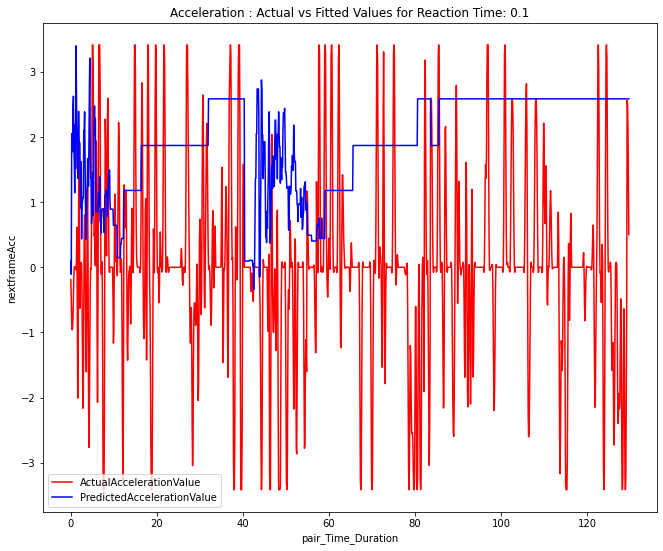

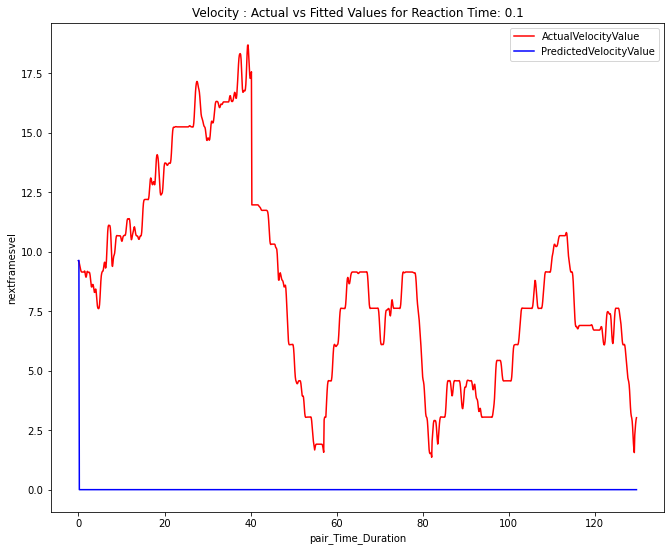

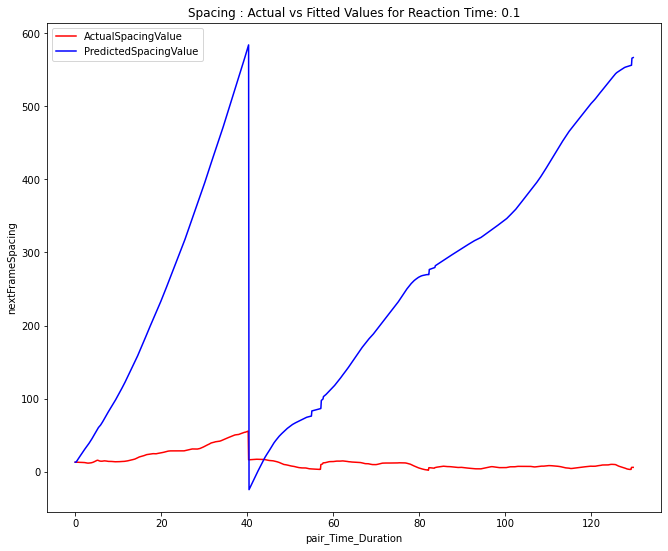

Prediction being done on :477-484
j: 0 input:[[12.94079208  2.          2.          0.097536    9.62253571]],subject localy:54.35163116455078,preceding_local_y:71.8148422241211,spacing:12.940792083740234 pred_acc: 0.10119360685348511
j: 1 input:[[ 1.29305300e+01  2.00000000e+00  2.00000000e+00 -2.07336545e-03
   9.63265507e+00]],subject localy:55.31439070314169,preceding_local_y:72.76612091064453,spacing:12.93053002744913 pred_acc: -0.10911840200424194
j: 2 input:[[12.96176763  2.          2.         -0.06175325  9.62174323]],subject localy:56.27711061775685,preceding_local_y:73.76007843017578,spacing:12.961767632365223 pred_acc: -0.12313920259475708
j: 3 input:[[12.97648159  2.          2.          0.16977305  9.60942931]],subject localy:57.238669244349005,preceding_local_y:74.7363510131836,spacing:12.976481588780878 pred_acc: -0.356006383895874
j: 4 input:[[12.94055935  2.          2.          0.55174825  9.57382867]],subject localy:58.19783214300871,preceding_local_y:75.659591674804

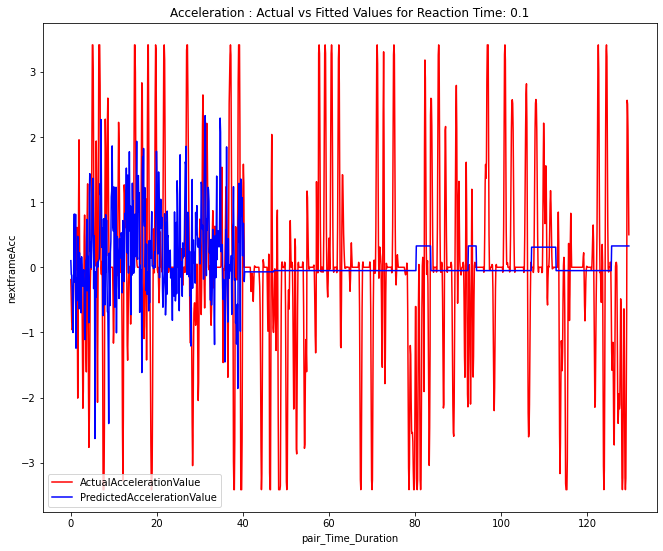

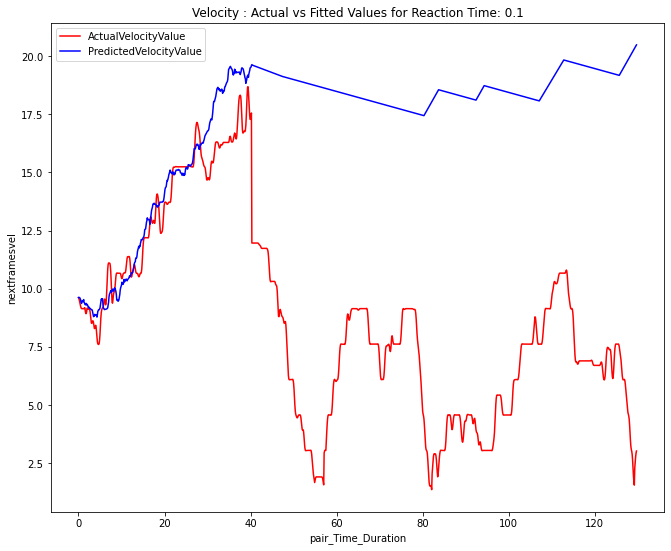

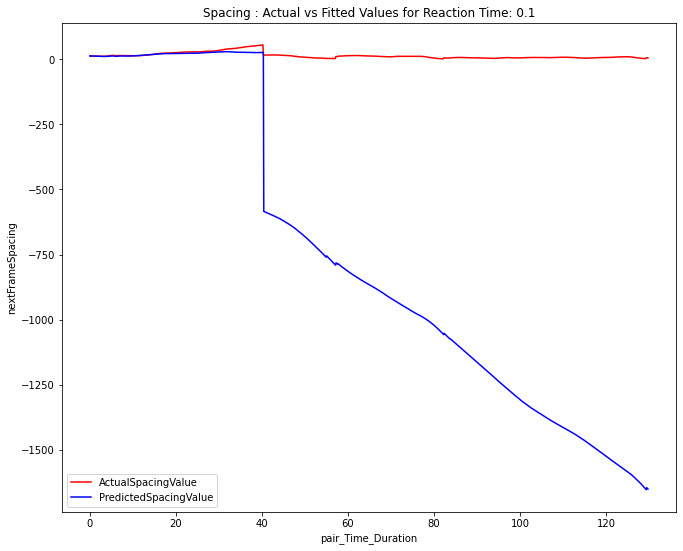

In [ ]:

fileProcessing.export_file(input_df,'input_df')

In [72]:
def prediction_same_notebook(test_df, test_range, target_variable, model, time_frame):

        delta_time = 0.1
        predicted_df = []
        # this loop runs for each pair required predictions.
        for current_pair in test_range:
            # Assign shape of the predictions
            input_df = []
            input_df = test_df[test_df['L-F_Pair'] == current_pair]
            spacing = np.zeros(input_df.shape[0])
            local_y_subject = np.zeros(input_df.shape[0])
            local_y_preceding = np.zeros(input_df.shape[0])
            dv = np.zeros(input_df.shape[0])
            vel = np.zeros(input_df.shape[0])
            pred_acc = np.zeros(input_df.shape[0])
            s_subject = np.zeros(input_df.shape[0])
            # updating the values for first Predictions
            vel[0] = input_df.iloc[0]['v_Vel']
            spacing[0] = input_df.iloc[0]['Rear_to_Front_Space_Headway']
            dv[0] = input_df.iloc[0]['Velocity Difference_Following-Preceding']

            local_y_subject[0] = input_df.iloc[0]['Local_Y']

            local_y_preceding[0] = input_df.iloc[0]['preceding_Local_Y']
            preceding_vehicle_class = input_df.iloc[0]['preceding_v_Class']
            vehicle_class = input_df.iloc[0]['v_Class']
            length_preceding_vehicle = input_df.iloc[0]['preceding_vehicle_length']
            #location = input_df.iloc[0]['Location_cat']

            predict_for_input = np.array(
                [spacing[0], preceding_vehicle_class, vehicle_class, dv[0], vel[0]]).reshape(1, -1)
            pred_acc[0] = model.predict(predict_for_input)
            print(
                f"j: {0} input:{predict_for_input},subject localy:{local_y_subject[0]},preceding_local_y:{local_y_preceding[0]},spacing:{spacing[0]} pred_acc: {pred_acc[0]}")
            vel[1] = vel[0]+(pred_acc[0] * delta_time)
            if vel[1] < 0:
                vel[1] = 0

            dv[1] = vel[1] - input_df.iloc[1]['preceding_Vehicle_Velocity']

            s_subject[0] = ((vel[0] * delta_time) +
                            (0.5*pred_acc[0]*pow(delta_time, 2)))
            # should be 1  second here
            print(f"row 0=s_subject:{s_subject[0]}")
            local_y_subject[1] = local_y_subject[0] + s_subject[0]
            local_y_preceding[1] = input_df.iloc[1]['preceding_Local_Y']

            spacing[1] = local_y_preceding[1] - \
                local_y_subject[1] - length_preceding_vehicle

            for j in range(1, len(input_df)):
                predict_for_input = np.array(
                    [spacing[j], preceding_vehicle_class, vehicle_class, dv[j], vel[j]]).reshape(1, -1)

                pred_acc[j] = model.predict(predict_for_input)
                if j == len(input_df)-1:
                    break

                vel[j+1] = vel[j]+(pred_acc[j]*0.1)

                if vel[j+1]<0:
                    vel[j+1] = 0

                dv[j+1] = vel[j+1] - input_df.iloc[j +
                                                   1]['preceding_Vehicle_Velocity']

                s_subject[j] = ((vel[j]*0.1) +
                                (0.5*pred_acc[j]*pow(0.1, 2)))

                local_y_subject[j+1] = local_y_subject[j] + s_subject[j]
                local_y_preceding[j+1] = input_df.iloc[j +
                                                       1]['preceding_Local_Y']

                spacing[j+1] = local_y_preceding[j+1] - \
                    local_y_subject[j+1] - length_preceding_vehicle

                print(
                    f"j: {j} input:{predict_for_input},subject localy:{local_y_subject[j]},preceding_local_y:{local_y_preceding[j]},spacing:{spacing[j]} pred_acc: {pred_acc[j]}")

            #print(f"input_df shape: {input_df.shape}")
            #print(f"pred_acc shape: {pred_acc.shape}")
            input_df['predicted_acceleration'] = pred_acc
            input_df['predicted_velocity'] = vel
            input_df['predicted_Local_Y'] = local_y_subject
            input_df['predicted_spacing'] = spacing
            input_df['preceding_Local_Y_used'] = local_y_preceding
            input_df['s_subject'] = s_subject
            predicted_df.append(input_df)

        result = pd.concat(predicted_df)
        return result


Prediction being done on :477-484
j: 0 input:[[12.94079208  2.          2.          0.097536    9.62253571]],subject localy:54.35163116455078,preceding_local_y:71.8148422241211,spacing:12.940792083740234 pred_acc: 0.10119360685348511
j: 1 input:[[ 1.29305300e+01  2.00000000e+00  2.00000000e+00 -2.07336545e-03
   9.63265507e+00]],subject localy:55.31439070314169,preceding_local_y:72.76612091064453,spacing:12.93053002744913 pred_acc: -0.10911840200424194
j: 2 input:[[12.96176763  2.          2.         -0.06175325  9.62174323]],subject localy:56.27711061775685,preceding_local_y:73.76007843017578,spacing:12.961767632365223 pred_acc: -0.12313920259475708
j: 3 input:[[12.97648159  2.          2.          0.16977305  9.60942931]],subject localy:57.238669244349005,preceding_local_y:74.7363510131836,spacing:12.976481588780878 pred_acc: -0.356006383895874
j: 4 input:[[12.94055935  2.          2.          0.55174825  9.57382867]],subject localy:58.19783214300871,preceding_local_y:75.659591674804

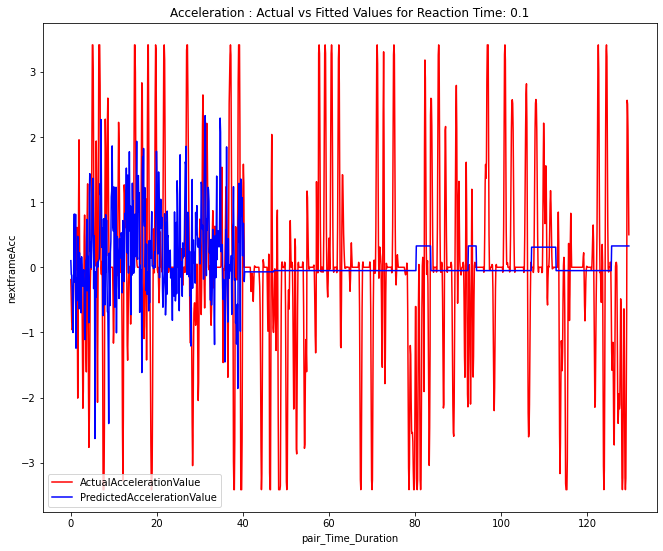

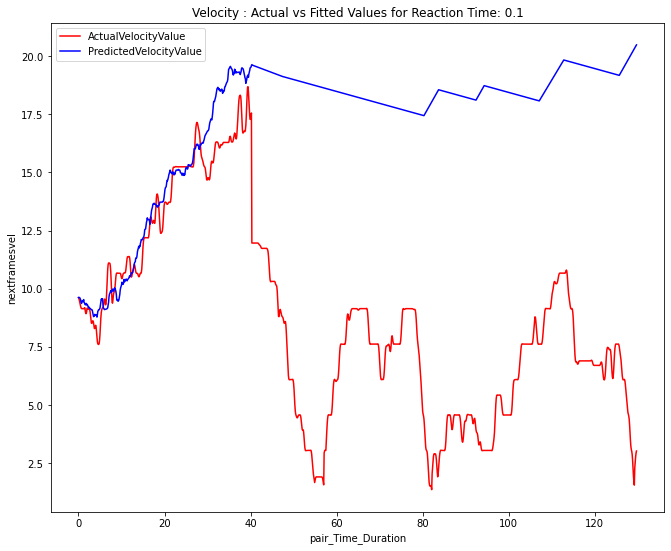

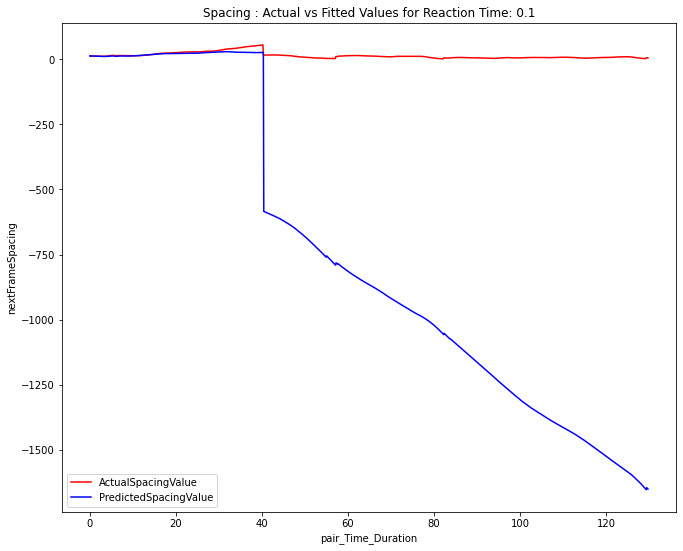

In [73]:
###prediction based on Neels' class
predict_on_pair=['477-484']
print(f"Prediction being done on :{predict_on_pair[0]}")
target_variable = 'nextframeAcc'

predicted_data_model_class=prediction(test_df, predict_on_pair,target_variable, model, time_frame)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_acceleration', 'nextframeAcc', 'Acceleration', delta_time)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_velocity', 'nextframesvel', 'Velocity', delta_time)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_spacing', 'nextFrameSpacing', 'Spacing', delta_time)


Prediction being done on :477-484
j: 0 input:[[12.94079208  2.          2.          0.097536    9.62253571]],subject localy:54.35163116455078,preceding_local_y:71.8148422241211,spacing:12.940792083740234 pred_acc: 0.10119360685348511
row 0=s_subject:0.962759538590908
j: 1 input:[[ 1.29305300e+01  2.00000000e+00  2.00000000e+00 -2.07336545e-03
   9.63265507e+00]],subject localy:55.31439070314169,preceding_local_y:72.76612091064453,spacing:12.93053002744913 pred_acc: -0.10911840200424194
j: 2 input:[[12.96176763  2.          2.         -0.06175325  9.62174323]],subject localy:56.27711061775685,preceding_local_y:73.76007843017578,spacing:12.961767632365223 pred_acc: -0.12313920259475708
j: 3 input:[[12.97648159  2.          2.          0.16977305  9.60942931]],subject localy:57.238669244349005,preceding_local_y:74.7363510131836,spacing:12.976481588780878 pred_acc: -0.356006383895874
j: 4 input:[[12.94055935  2.          2.          0.55174825  9.57382867]],subject localy:58.19783214300871

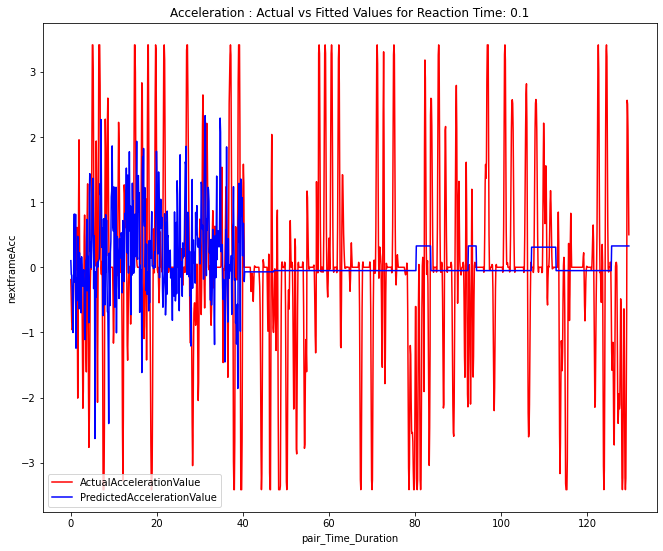

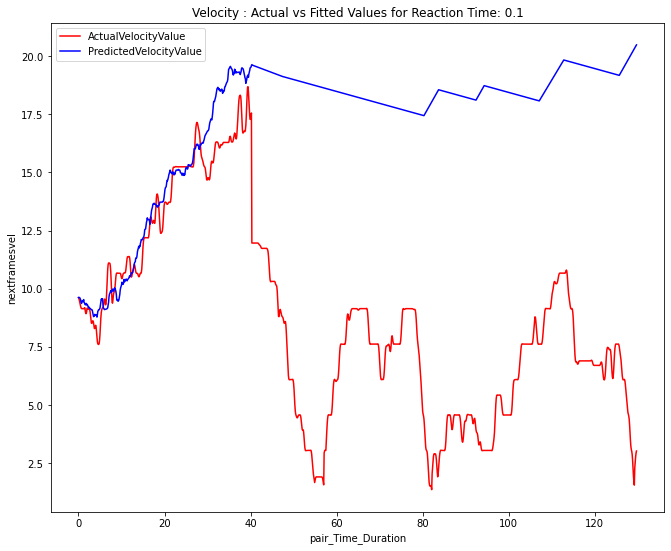

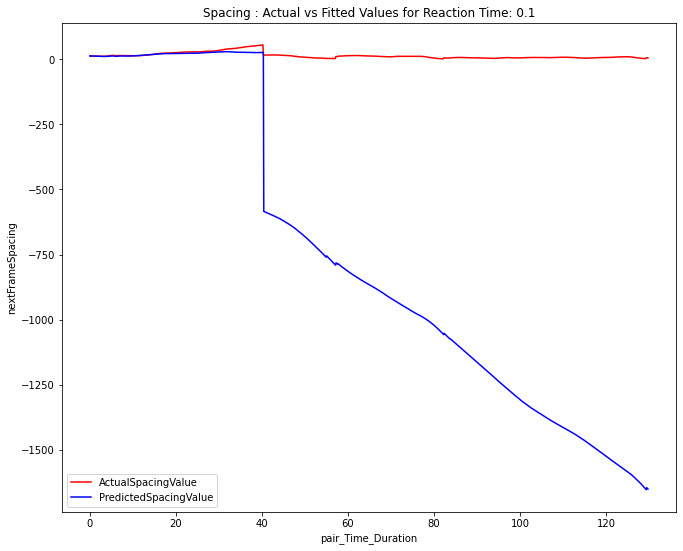

In [74]:
###prediction based on Vineets original formulas class
predict_on_pair=['477-484']
print(f"Prediction being done on :{predict_on_pair[0]}")
target_variable = 'nextframeAcc'

predicted_data_model_class=prediction_same_notebook(test_df, predict_on_pair,'nextframeAcc', model, time_frame)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_acceleration', 'nextframeAcc', 'Acceleration', delta_time)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_velocity', 'nextframesvel', 'Velocity', delta_time)
model_obj.plot_prediction(predicted_data_model_class, 'pair_Time_Duration',
                        'predicted_spacing', 'nextFrameSpacing', 'Spacing', delta_time)
